In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
from torch.autograd import gradcheck
torch.manual_seed(42)
import random
random.seed(0)
np.random.seed(0)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
def mass_spring(p_0, q_0, t):
    return p_0*np.cos(t) - q_0*np.sin(t), p_0*np.sin(t) + q_0*np.cos(t)
def hamiltonian(p, q):
    return 0.5 * (p**2 + q**2)

num_samples = 1000
num_steps = 30
dataset = np.zeros((num_samples, num_steps, 3))


for sample in range(num_samples):

    # p0 = np.random.uniform(-1, 1)
    # q0 = np.random.uniform(0.5, 1.5) 
    y0 = np.random.rand(2)*2-1
    radius = np.random.rand()*0.9 + 0.1
    y0 = y0 / np.sqrt((y0**2).sum()) * radius
    p0 = y0[0]
    q0 = y0[0]

    p_values = np.zeros(num_steps)
    q_values = np.zeros(num_steps)
    h_values = np.zeros(num_steps)

    p = p0
    q = q0

    p_values[0] = p
    q_values[0] = q
    h_values[0] = hamiltonian(p,q)

    for i in range(1, num_steps):
        p, q = mass_spring(p0, q0, i)
        p_values[i] = p
        q_values[i] = q
        h_values[i] = hamiltonian(p, q)
    dataset[sample, :, 0] = p_values
    dataset[sample, :, 1] = q_values
    dataset[sample, :, 2] = h_values
print(dataset.shape)
# np.save("mass_spring_30.npy", dataset)

(1000, 30, 3)


In [7]:
def hamiltonian_dynamics(x):
    return np.array([-x[1], x[0]])

def euler_step(x, func, dt):
    return x + func(x)*dt

def leapfrog_step(x, func, dt):
    x[0] += 0.5 * func(x)[0] * dt
    x[1] += func(x)[1] * dt
    x[0] += 0.5 * func(x)[0] * dt
    return x

def predictor_step(y, h, func):
    k1 = func(y)
    k2 = func(y + 0.5 * h * k1)
    return y + h * k2

def corrector_step(x, x_, func, dt, iter = 1):
    p = x_[0]
    q = x_[1]

    for i in range(iter):
        p_ = x[0] + 0.5*dt*func(np.array([p, x[1]]))[0]
        p = p_ + 0.5*dt*func(np.array([p_, q]))[0]
        q = x[1] + 0.5*dt*(func(np.array([p_, x[1]]))[1] + func(np.array([p_, q]))[1])
        # p_next = (x[0] + p)/2
        # coor1 = np.array([p_next, x[1]])
        # coor2 = np.array([p_next, q])
        # p = x[0] + dt*0.5*(func(coor1)[0] + func(coor2)[0])
        # q = x[1] + dt*0.5*(func(coor1)[1] + func(coor2)[1])
    return np.array([p, q])
    
def predictor_corrector(x, func, dt, iter = 1):
    x_ = predictor_step(x, dt, func)
    x_next = corrector_step(x, x_, func, dt, iter)
    return x_next

integrator_dict = {
    'euler' : euler_step,
    'leapfrog' : leapfrog_step,
    'pc' : predictor_corrector
}

def generate_trajectory(num_samples, integrator, dt, **kwargs):
    simulated_trajectory = np.zeros((num_samples, 30, 3))
    timesteps = simulated_trajectory.shape[1]
    dt = dt
    for sample in tqdm(range(simulated_trajectory.shape[0])):
        y0 = np.random.rand(2)*2-1
        radius = np.random.rand()*0.9 + 0.1
        y0 = y0 / np.sqrt((y0**2).sum()) * radius
        p0 = y0[0]
        q0 = y0[0]
        simulated_trajectory[sample, 0, 0] = p0
        simulated_trajectory[sample, 0, 1] = q0
        p = simulated_trajectory[sample, 0, 0]
        q = simulated_trajectory[sample, 0, 1]
        for time in range(1, timesteps):
            num_steps = int(1/dt)
            for _ in range(num_steps):
                x = integrator_dict[integrator](np.array([p, q]), hamiltonian_dynamics, dt, **kwargs)
                p = x[0]
                q = x[1]
            simulated_trajectory[sample, time, 0] = p
            simulated_trajectory[sample, time, 1] = q
            simulated_trajectory[sample, time, 2] = hamiltonian(p, q)
    return simulated_trajectory

In [334]:
# trajectory, euler_trajectory = generate_trajectory("euler", 0.001)
leapfrog_trajectory = generate_trajectory(1000, "leapfrog", 0.001)
# np.save("leapfrog_mass_spring_30_train.npy", leapfrog_trajectory)
# _, pc_trajectory = generate_trajectory("pc", 0.001, iter = 1)

  3%|█▎                                       | 32/1000 [00:03<01:34, 10.29it/s]


KeyboardInterrupt: 

In [ ]:
val_leapfrog_trajectory = generate_trajectory(250, "leapfrog", 0.001)
# np.save("leapfrog_mass_spring_30_val.npy", leapfrog_trajectory)

test_leapfrog_trajectory = generate_trajectory(250, "leapfrog", 0.001)
# np.save("leapfrog_mass_spring_30_test.npy", leapfrog_trajectory)

In [335]:
def l2_error(arr1, arr2, index):
    return np.mean(np.linalg.norm(arr1[:, :, index] - arr2[:, :, index], axis = 1))
print("euler p")
print(l2_error(trajectory, euler_trajectory, 0))
print("leapfrog p")
print(l2_error(trajectory, leapfrog_trajectory, 0))
print("pc p")
print(l2_error(trajectory, pc_trajectory, 0))

print("euler q")
print(l2_error(trajectory, euler_trajectory, 1))
print("leapfrog q")
print(l2_error(trajectory, leapfrog_trajectory, 1))
print("pc q")
print(l2_error(trajectory, pc_trajectory, 1))

print("euler h")
print(l2_error(trajectory, euler_trajectory, 2))
print("leapfrog h")
print(l2_error(trajectory, leapfrog_trajectory, 2))
print("pc h")
print(l2_error(trajectory, pc_trajectory, 2))


euler p


NameError: name 'euler_trajectory' is not defined

In [8]:
class HarmonicOscillatorDataset(Dataset):
    def __init__(self, file_path):
        # Load the dataset
        dataset = np.load(file_path)
        
        # Convert the dataset to PyTorch tensors
        self.p_values = torch.tensor(dataset[:, :, 0], dtype=torch.float32)
        self.q_values = torch.tensor(dataset[:, :, 1], dtype=torch.float32)
        self.h_values = torch.tensor(dataset[:, :, 2], dtype=torch.float32)
        
        # Ensure consistent length for all tensors
        assert len(self.p_values) == len(self.q_values) == len(self.h_values)
        self.length = len(self.p_values)
    
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        return self.p_values[idx], self.q_values[idx], self.h_values[idx]

In [9]:
class MLP1H_Separable_Hamilt(nn.Module):
    def __init__(self, n_hidden = 256, input_size = 1):
        super(MLP1H_Separable_Hamilt, self).__init__()
        self.linear_K1 = nn.Linear(input_size, n_hidden)
        self.linear_K2 = nn.Linear(n_hidden, 1)
        self.linear_P1 = nn.Linear(input_size, n_hidden)
        self.linear_P2 = nn.Linear(n_hidden, 1)

    def kinetic_energy(self, p):
        h_pre = self.linear_K1(p)
        h = h_pre.tanh_()
        return self.linear_K2(h)

    def potential_energy(self, q):
        h_pre = self.linear_P1(q)
        h = h_pre.tanh_()
        return self.linear_P2(h)

    def forward(self, p, q):
        return self.kinetic_energy(p) + self.potential_energy(q)

In [10]:
class MLP2H_Separable_Hamilt(nn.Module):
    def __init__(self, n_hidden, input_size):
        super(MLP2H_Separable_Hamilt, self).__init__()
        self.linear_K1 = nn.Linear(input_size, n_hidden)
        self.linear_K1B = nn.Linear(n_hidden, n_hidden)
        self.linear_K2 = nn.Linear(n_hidden, 1)
        self.linear_P1 = nn.Linear(input_size, n_hidden)
        self.linear_P1B = nn.Linear(n_hidden, n_hidden)
        self.linear_P2 = nn.Linear(n_hidden, 1)

    def kinetic_energy(self, p):
        h_pre = self.linear_K1(p)
        h = h_pre.tanh_()
        h_pre_B = self.linear_K1B(h)
        h_B = h_pre_B.tanh_()
        return self.linear_K2(h_B)

    def potential_energy(self, q):
        h_pre = self.linear_P1(q)
        h = h_pre.tanh_()
        h_pre_B = self.linear_P1B(h)
        h_B = h_pre_B.tanh_()
        return self.linear_P2(h_B)

    def forward(self, p, q):
        return self.kinetic_energy(p) + self.potential_energy(q)

In [11]:
class BackProp_HNN(nn.Module):
    def __init__(self, f, T, dt, dim, integrator, iter):
        super(BackProp_HNN, self).__init__()
        self.f = f
        self.dt = dt
        self.dim = dim
        self.integrator = integrator
        self.T = T
        self.num_steps = int(1/dt)
        self.iter = iter
        
    def forward(self, p0, q0):
        trajectories = torch.zeros((p0.shape[0], self.T, self.dim * 2))
        trajectories[:, 0, 0] = p0
        trajectories[:, 0, 1] = q0
        p = p0
        q = q0
        for timestep in range(1, T):
            for _ in range(self.num_steps):
                if self.integrator == "euler":
                    x = self.euler_step(torch.stack([p, q], dim = 1))
                elif self.integrator == "leapfrog":
                    x = self.leapfrog_step(torch.stack([p, q], dim = 1))
                else:
                    x = self.pc_step(torch.stack([p, q], dim = 1))
                p = x[:, 0]
                q = x[:, 1]
            trajectories[:, timestep, 0] = p
            trajectories[:, timestep, 1] = q
        return trajectories
    
    def euler_step(self, x):
        return x + self.dt * self.dynamics_fn(x)
    
    def leapfrog_step(self, x):
        p_ = x[:, 0] + 0.5 * self.dt * self.dynamics_fn(x)[:, 0]
        q = x[:, 1] + self.dt * self.dynamics_fn(torch.stack([p_, x[:, 1]], dim = 1))[:, 1]
        p = p_ + 0.5 * self.dt * self.dynamics_fn(torch.stack([p_, q], dim = 1))[:, 0]
        return torch.stack([p, q], dim = 1)
    
    def predictor_step(self, x):
        k1 = self.dynamics_fn(x)
        k2 = self.dynamics_fn(x + 0.5 * self.dt * k1)
        return x + self.dt * k2
    
    def corrector_step(self, x, x_):
        p = x_[0]
        q = x_[1]
        for _ in range(self.iter):
            p_ = x[0] + 0.5 * self.dt * self.dynamics_fn(torch.stack([p, x[1]]))[0]
            p = p_ + 0.5 * self.dt * self.dynamics_fn(torch.stack([p_, q]))[0]
            q = x[1] + 0.5 * self.dt * (self.dynamics_fn(torch.stack([p_, x[1]]))[1] + self.dynamics_fn(torch.stack([p_, q]))[1])
        return torch.stack([p, q])
    
    def pc_step(self, x):
        x_ = self.predictor_step(x)
        return self.corrector_step(x, x_)
        
    def dynamics_fn(self, x):
        p = x[:, 0]
        q = x[:, 1]
        p.requires_grad_(True)
        q.requires_grad_(True)
        h = self.f(p.unsqueeze(-1), q.unsqueeze(-1))
        grad_p, = grad(h.sum(), p, create_graph=True, allow_unused=True)
        grad_q, = grad(h.sum(), q, create_graph=True, allow_unused=True)
        return torch.stack([-grad_q, grad_p], dim = 1)

In [12]:
class Hamiltonian_Adjoint(torch.autograd.Function):
    @staticmethod
    def forward(ctx, p0, q0, f, T, dt, back_dt, dim, integrator, back_integrator, iter, *adjoint_params):
        with torch.no_grad():
            trajectories = torch.zeros((p0.shape[0], T, dim * 2))
            trajectories[:, 0, 0] = p0
            trajectories[:, 0, 1] = q0
            p = p0
            q = q0
            num_steps = int(1/dt)
            if integrator == "euler":
                integrate_fn = Hamiltonian_Adjoint.euler_step
            elif integrator == "second_order":
                integrate_fn = Hamiltonian_Adjoint.heuns_method
            dynamics = Hamiltonian_Adjoint.dynamics_fn
            for timestep in range(1, T):
                for _ in range(num_steps):
                    x = integrate_fn([torch.stack([p, q], dim = 1)], dynamics, f, dt)[0]
                    p = x[:, 0]
                    q = x[:, 1]
                trajectories[:, timestep, 0] = p
                trajectories[:, timestep, 1] = q
            ctx.save_for_backward(trajectories, p0, q0, *adjoint_params)
            ctx.T = T
            ctx.dt = dt
            ctx.dim = dim
            ctx.back_integrator = back_integrator
            ctx.iter = iter
            ctx.back_dt = back_dt
            ctx.f = f
            return trajectories[:, :, 0], trajectories[:, :, 1]
    
    @staticmethod
    def backward(ctx, dldp, dldq):
        with torch.no_grad():
            trajectories, p0, q0, *adjoint_params = ctx.saved_tensors
            T = ctx.T
            dt = ctx.dt
            dim = ctx.dim
            back_integrator = ctx.back_integrator
            back_dt = ctx.back_dt
            if back_integrator == "euler":
                integrate_fn = Hamiltonian_Adjoint.euler_step
            elif back_integrator == "second_order":
                integrate_fn = Hamiltonian_Adjoint.heuns_method
            aug_state = [trajectories[:, -1, 0], trajectories[:, -1, 1], dldp[:, -1], dldq[:, -1]] #(p, q, adjp, adjq, theta)
            aug_state.extend([torch.zeros_like(param) for param in adjoint_params])
            num_steps = int(1/back_dt)
            f = ctx.f
            
            def augmented_dynamics(y_aug, Func):
                #get p and q at current time step
                p = y_aug[0]
                q = y_aug[1]
                with torch.enable_grad():
                    p = p.detach().requires_grad_(True)
                    q = q.detach().requires_grad_(True)
                    H = Func(p.unsqueeze(-1), q.unsqueeze(-1))
                    # following three lines are necessary to bypass a bug in pytorch's autograd function, and do not contribute the actual algorithm whatsoever
                    _p = torch.as_strided(p, (), ())  # noqa
                    _q = torch.as_strided(q, (), ())  # noqa
                    _params = tuple(torch.as_strided(param, (), ()) for param in adjoint_params)
                    #partial gradient of Hamiltonian with respect to p and q
                    dhdp, = torch.autograd.grad(H.sum(), p, allow_unused = True, retain_graph = True, create_graph = True)
                    dhdq, = torch.autograd.grad(H.sum(), q, allow_unused = True, retain_graph = True, create_graph = True)
                    #partial gradient of Hamiltonian with p and q, the vector jacobian product being -adjoint_q, -lambda_q*dh/dpdq
                    dhdpdq_1 = torch.autograd.grad(dhdp, q, -y_aug[3], allow_unused=True, retain_graph=True)
                    #partial gradient of Hamiltonian with p and q, the vector jacobian product being adjoint_p, lambda_p*dh/dpdq
                    dhdpdq_2 = torch.autograd.grad(dhdp, q, y_aug[2], allow_unused=True, retain_graph=True)
                    #double partial gradients with respect to p and q adjusted by respective jacobian products as in the formula
                    #-lambda_q*dh/dpdp
                    dhdpdp = torch.autograd.grad(dhdp, p, -y_aug[3], allow_unused=True, retain_graph=True)
                    #lambda_p*dh/dqdq
                    dhdqdq = torch.autograd.grad(dhdq, q, y_aug[2], allow_unused=True, retain_graph=True)
                    #partial gradients with respect to parameters, p and q adjusted with respective adjoints as given in the formula
                    # -lambda_q*dh/dpdtheta
                    dhdpdw = torch.autograd.grad(dhdp, adjoint_params, -y_aug[3], allow_unused=True, retain_graph=True)
                    #lambda_p*dh/dqdtheta
                    dhdqdw = torch.autograd.grad(dhdq, adjoint_params, y_aug[2], allow_unused=True, retain_graph=True)
                    dhdpdq_1 = [torch.zeros_like(p) if param is None else param for param in dhdpdq_1]
                    dhdpdq_2 = [torch.zeros_like(q) if param is None else param for param in dhdpdq_2]
                    #setting gradients zero for parameters which may not directly contribute to Hamiltonian calculation at different time steps
                    dhdpdp = torch.zeros_like(p) if dhdpdp is None else dhdpdp
                    dhdqdq = torch.zeros_like(q) if dhdqdq is None else dhdqdq
                    dhdpdw = [torch.zeros_like(param) if vjp_param is None else vjp_param
                              for param, vjp_param in zip(adjoint_params, dhdpdw)]
                    dhdqdw = [torch.zeros_like(param) if vjp_param is None else vjp_param
                              for param, vjp_param in zip(adjoint_params, dhdqdw)]
                    #final gradient calculation (lambda_p*dh/dqdtheta - lambda_q*dh/dpdtheta)
                    dw = list(dhdp_param + dhdq_param for dhdp_param, dhdq_param in zip(dhdpdw, dhdqdw))
                    f_p = -dhdq
                    f_q = dhdp
                    #lambda_p = -lambda_q*dh/dpdq + lambda_p*dh/dqdq
                    adjoint_p = dhdpdq_1[0] + dhdqdq[0]
                    #lambda_q = -lambda_q*dh/dpdp + lambda_p*dh/dpdq
                    adjoint_q = dhdpdp[0] + dhdpdq_2[0]
                    return [f_p, f_q, adjoint_p, adjoint_q, *dw]
        
            #function for calculating dl/dtheta when adjoint_p and adjpoint_q are available at t = 0
            def get_final_gradient(y_aug, Func):
                p = y_aug[0]
                q = y_aug[1]
                with torch.enable_grad():
                    p = p.detach().requires_grad_(True)
                    q = q.detach().requires_grad_(True)
                    H = Func(p.unsqueeze(-1), q.unsqueeze(-1))
                    _p = torch.as_strided(p, (), ())  # noqa
                    _q = torch.as_strided(q, (), ())  # noqa
                    _params = tuple(torch.as_strided(param, (), ()) for param in adjoint_params)
                    dhdp, = torch.autograd.grad(H.sum(), p, allow_unused = True, retain_graph = True, create_graph = True)
                    dhdq, = torch.autograd.grad(H.sum(), q, allow_unused = True, retain_graph = True, create_graph = True)
                    dhdpdq_1 = torch.autograd.grad(dhdp, q, -y_aug[3], allow_unused=True, retain_graph=True)
                    dhdpdq_2 = torch.autograd.grad(dhdp, q, y_aug[2], allow_unused=True, retain_graph=True)
                    dhdpdp = torch.autograd.grad(dhdp, p, -y_aug[3], allow_unused=True, retain_graph=True)
                    dhdqdq = torch.autograd.grad(dhdq, q, y_aug[2], allow_unused=True, retain_graph=True)
                    dhdpdw = torch.autograd.grad(dhdp, adjoint_params, -y_aug[3], allow_unused=True, retain_graph=True)
                    dhdqdw = torch.autograd.grad(dhdq, adjoint_params, y_aug[2], allow_unused=True, retain_graph=True)
                    dhdpdq_1 = [torch.zeros_like(p) if param is None else param for param in dhdpdq_1]
                    dhdpdq_2 = [torch.zeros_like(q) if param is None else param for param in dhdpdq_2]
                    dhdpdp = torch.zeros_like(p) if dhdpdp is None else dhdpdp
                    dhdqdq = torch.zeros_like(q) if dhdqdq is None else dhdqdq
                    dhdpdw = [torch.zeros_like(param) if vjp_param is None else vjp_param
                              for param, vjp_param in zip(adjoint_params, dhdpdw)]
                    dhdqdw = [torch.zeros_like(param) if vjp_param is None else vjp_param
                              for param, vjp_param in zip(adjoint_params, dhdqdw)]
                    # print(len(dhdpdw))
                    # print("dhdpdw", dhdpdw[-1][:10])
                    dw = list(dhdp_param + dhdq_param for dhdp_param, dhdq_param in zip(dhdpdw, dhdqdw))
                    f_p = -dhdq
                    f_q = dhdp
                    adjoint_p = dhdpdq_1[0] + dhdqdq[0]
                    adjoint_q = dhdpdp[0] + dhdpdq_2[0]
                    return dw
        
            for i in range(T-1, -1, -1):
                for _ in range(num_steps):
                    aug_state = integrate_fn(aug_state, augmented_dynamics, f, back_dt)
                    # aug_state = [p_next, q_next, vjp_p_next, vjp_q_next, *dw_next]
                #setting p and q for the next time step
                aug_state[0] = trajectories[:, i-1, 0]
                aug_state[1] = trajectories[:, i-1, 1]
                #adding direct gradients due to intermediate points
                aug_state[2] += dldp[:, i-1]
                aug_state[3] += dldq[:, i-1]
            
            #getting adjoint_p and adjoint_q at t = 0
            adj_p = aug_state[2]
            adj_q = aug_state[3]
            # dl/dtheta = adjoint_p(0)*dh/dq(0)dtheta - adjoint_q(0)*dh/dp(0)dtheta
            adj_params = get_final_gradient(aug_state, f)
            # adj_params = aug_state[4:]
            # print("adjp", adj_p[0])
            # print("adjq", adj_q[0])
        return adj_p, adj_q, None, None, None, None, None, None, None, None, *adj_params 
    
    @staticmethod
    def euler_step(x, dynamics, f, dt):
        out = dynamics(x, f)
        result = [xi + dt * yi for xi, yi in zip(x, out)]
        return result
    
    @staticmethod 
    def heuns_method(x, dynamics, f, dt):
        # Heun's method
        # k1 = func(y)
        # k2 = func(y + 0.5 * h * k1)
        # return y + h * k2
        k1_ = dynamics(x, f)
        k2__ = [x_ + 0.5 * dt * k1 for x_, k1 in zip(x, k1_)]
        k2_ = dynamics(k2__, f)
        result = [x_ + 0.5 * dt * k2 for x_, k2 in zip(x, k2_)]
        return result
    
    def verlet_implicit(x, dynamics, f, dt):
        pass
    
    @staticmethod
    def predictor_corrector(x, dynamics, f, dt, predictor, corrector):
        pass
#         predict = predictor(x, dynamics, f, dt)
#         result = corrector(x, dynamics, f, dt, predict)
#         return result
        
    
    @staticmethod
    def dynamics_fn(x, f):
        x_ = x[0]
        p = x_[:, 0]
        q = x_[:, 1]
        with torch.enable_grad():
            p.requires_grad_(True)
            q.requires_grad_(True)
            h = f(p.unsqueeze(-1), q.unsqueeze(-1))
            grad_p, = grad(h.sum(), p, create_graph=True, allow_unused=True)
            grad_q, = grad(h.sum(), q, create_graph=True, allow_unused=True)
            return [torch.stack([-grad_q, grad_p], dim = 1)]

In [13]:
def hnn_adjoint(func, x, T, dt, back_dt, dim, integrator, back_integrator, iter):
    adjoint_params = tuple(list(func.parameters()))
    adjoint_params = tuple(p for p in adjoint_params if p.requires_grad)
    p, q = Hamiltonian_Adjoint.apply(x[:, 0], x[:, 1], func, T, dt, back_dt, dim, integrator, back_integrator, iter, *adjoint_params)
    return p, q

class Symplectic_HNN(nn.Module):
    def __init__(self, f, T = 30, dt = 0.1, back_dt = 0.1, integrator = "euler", back_integrator = "euler", dim = 1, iter = 1):
        super(Symplectic_HNN, self).__init__()
        self.func = f
        self.T = T
        self.dt = dt
        self.back_dt = back_dt
        self.dim = dim
        self.integrator = integrator
        self.back_integrator = back_integrator
        self.iter = iter
        
    def forward(self, p0, q0):
        p, q = hnn_adjoint(self.func, torch.stack([p0, q0], dim = 1), self.T, self.dt, self.back_dt, self.dim, self.integrator, self.back_integrator, self.iter)
        p = torch.unsqueeze(p, dim = -1)
        q = torch.unsqueeze(q, dim = -1)
        return torch.cat([p, q], dim = -1)

In [14]:
f1 = MLP2H_Separable_Hamilt(n_hidden=256, input_size=1).to(device)

# Clone f1 to create f2
f2 = MLP2H_Separable_Hamilt(n_hidden=256, input_size=1).to(device)

# Copy parameters from f1 to f2
f2.load_state_dict(f1.state_dict())

params_equal = all(torch.allclose(p1, p2) for p1, p2 in zip(f1.parameters(), f2.parameters()))
print("Are the parameters equal between f1 and f2?", params_equal)

Are the parameters equal between f1 and f2? True


In [15]:
T = 30
dt = 0.1
back_dt = 0.1
dim = 1
num_epochs = 10
iter = 1
integrator = "second_order"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# f = MLP2H_Separable_Hamilt(n_hidden = 256, input_size = 1).to(device)
model = Symplectic_HNN(f2, T, dt, back_dt, integrator, integrator, dim, iter).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_mass_spring = HarmonicOscillatorDataset("leapfrog_mass_spring_30_train.npy")
data_loader = DataLoader(train_mass_spring, batch_size=32, shuffle=False)
val_mass_spring = HarmonicOscillatorDataset("leapfrog_mass_spring_30_val.npy")
val_loader = DataLoader(val_mass_spring, batch_size=32, shuffle=False)

train_loss = []
val_loss = []

best_val_loss = float('inf')
best_model_path = integrator+'_best_model_adjoint.pt'

for epoch in tqdm(range(num_epochs)):
    model.train()
    loss_epoch = []
    for batch in data_loader:
        optimizer.zero_grad()
        p_batch, q_batch, _ = batch
        p0_batch = p_batch[:, 0].to(device)
        q0_batch = q_batch[:, 1].to(device)
        simulated_trajectory = model(p0_batch, q0_batch)
        print("simulated trajectory", simulated_trajectory[0, :, 0])
        simulated_trajectory = simulated_trajectory.view(simulated_trajectory.size(0), -1)
        trajectory = torch.stack([p_batch, q_batch], axis=2).to(device)
        trajectory = trajectory.view(trajectory.size(0), -1).to(device)
        loss = criterion(trajectory, simulated_trajectory)
        print(loss.item())
        loss.backward()
        optimizer.step()
        for name, param in f2.named_parameters():
            print(name, param.grad[:10])
            break
        loss_epoch.append(loss.item())
    avg_train_loss = sum(loss_epoch)/len(loss_epoch)
    train_loss.append(avg_train_loss)
    
#     # Validation phase
#     model.eval()  # Set model to evaluation mode
#     val_loss_epoch = []
#     # with torch.no_grad():
#     for batch in val_loader:
#         optimizer.zero_grad()
#         p_batch, q_batch, _ = batch
#         p0_batch = p_batch[:, 0].to(device)
#         q0_batch = q_batch[:, 1].to(device)
#         simulated_trajectory = model(p0_batch, q0_batch)
#         simulated_trajectory = simulated_trajectory.view(simulated_trajectory.size(0), -1)
#         trajectory = torch.stack([p_batch, q_batch], axis=2).to(device)
#         trajectory = trajectory.view(trajectory.size(0), -1).to(device)
#         loss = criterion(trajectory, simulated_trajectory)
#         val_loss_epoch.append(loss.item())
#     avg_val_loss = sum(val_loss_epoch)/len(val_loss_epoch)
#     val_loss.append(avg_val_loss)
#     # Check if the validation loss is the lowest seen so far
#     if avg_val_loss < best_val_loss:
#         best_val_loss = avg_val_loss
#         # Save the model
#         torch.save(model.state_dict(), best_model_path)
#     print(f"Epoch {epoch+1}, Average Train Loss: {avg_train_loss}, Average Val Loss: {avg_val_loss}")

  0%|                                                    | 0/10 [00:00<?, ?it/s]

simulated trajectory tensor([0.1909, 0.2597, 0.3316, 0.4067, 0.4852, 0.5671, 0.6525, 0.7413, 0.8335,
        0.9288, 1.0272, 1.1284, 1.2320, 1.3377, 1.4452, 1.5541, 1.6641, 1.7749,
        1.8860, 1.9974, 2.1087, 2.2198, 2.3306, 2.4410, 2.5509, 2.6603, 2.7691,
        2.8775, 2.9854, 3.0927], grad_fn=<SelectBackward0>)
1.9435681104660034
linear_K1.weight tensor([[-0.0014],
        [ 0.0007],
        [-0.0002],
        [ 0.0006],
        [-0.0125],
        [-0.0031],
        [-0.0009],
        [-0.0037],
        [ 0.0011],
        [ 0.0012]])
simulated trajectory tensor([-0.0928,  0.3861,  0.8485,  1.2519,  1.5803,  1.8430,  2.0556,  2.2309,
         2.3786,  2.5054,  2.6161,  2.7139,  2.8014,  2.8806,  2.9527,  3.0190,
         3.0804,  3.1374,  3.1908,  3.2409,  3.2882,  3.3330,  3.3755,  3.4161,
         3.4548,  3.4919,  3.5275,  3.5618,  3.5948,  3.6267],
       grad_fn=<SelectBackward0>)
19.571203231811523


  0%|                                                    | 0/10 [00:11<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
T = 30
dt = 0.1
dim = 1
num_epochs = 10
iter = 1
integrator = "euler"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# f = MLP2H_Separable_Hamilt(n_hidden = 256, input_size = 1).to(device)
model = BackProp_HNN(f1, T, dt, dim, integrator, iter).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_mass_spring = HarmonicOscillatorDataset("leapfrog_mass_spring_30_train.npy")
data_loader = DataLoader(train_mass_spring, batch_size=32, shuffle=False)
val_mass_spring = HarmonicOscillatorDataset("leapfrog_mass_spring_30_val.npy")
val_loader = DataLoader(val_mass_spring, batch_size=32, shuffle=False)

train_loss = []
val_loss = []

best_val_loss = float('inf')
best_model_path = integrator+'_best_model.pt'

for epoch in tqdm(range(num_epochs)):
    model.train()
    loss_epoch = []
    for batch in data_loader:
        optimizer.zero_grad()
        p_batch, q_batch, _ = batch
        p0_batch = p_batch[:, 0].to(device)
        q0_batch = q_batch[:, 1].to(device)
        simulated_trajectory = model(p0_batch, q0_batch)
        # print("simulated trajectory", simulated_trajectory[0, :, 0])
        simulated_trajectory = simulated_trajectory.view(simulated_trajectory.size(0), -1)
        trajectory = torch.stack([p_batch, q_batch], axis=2).to(device)
        trajectory = trajectory.view(trajectory.size(0), -1).to(device)
        loss = criterion(trajectory, simulated_trajectory)
        print(loss.item())
        loss.backward()
        optimizer.step()
        # for name, param in f1.named_parameters():
        #     print(name, param.grad[:10])
        #     break
        loss_epoch.append(loss.item())
    avg_train_loss = sum(loss_epoch)/len(loss_epoch)
    train_loss.append(avg_train_loss)
    
#     # Validation phase
#     model.eval()  # Set model to evaluation mode
#     val_loss_epoch = []
#     # with torch.no_grad():
#     for batch in val_loader:
#         optimizer.zero_grad()
#         p_batch, q_batch, _ = batch
#         p0_batch = p_batch[:, 0].to(device)
#         q0_batch = q_batch[:, 1].to(device)
#         simulated_trajectory = model(p0_batch, q0_batch)
#         simulated_trajectory = simulated_trajectory.view(simulated_trajectory.size(0), -1)
#         trajectory = torch.stack([p_batch, q_batch], axis=2).to(device)
#         trajectory = trajectory.view(trajectory.size(0), -1).to(device)
#         loss = criterion(trajectory, simulated_trajectory)
#         val_loss_epoch.append(loss.item())
#     avg_val_loss = sum(val_loss_epoch)/len(val_loss_epoch)
#     val_loss.append(avg_val_loss)
#     # Check if the validation loss is the lowest seen so far
#     if avg_val_loss < best_val_loss:
#         best_val_loss = avg_val_loss
#         # Save the model
#         torch.save(model.state_dict(), best_model_path)
#     print(f"Epoch {epoch+1}, Average Train Loss: {avg_train_loss}, Average Val Loss: {avg_val_loss}")

In [158]:
values_equal = torch.allclose(simulated_trajectory_backprop, simulated_trajectory_adjoint)
values_equal

True

In [159]:
print(simulated_trajectory_backprop[0, :30])
print(simulated_trajectory_adjoint[0, :30])

tensor([ 0.1909,  0.2638,  0.0940,  0.1593,  0.0093,  0.0585, -0.0637, -0.0390,
        -0.1259, -0.1337, -0.1780, -0.2260, -0.2210, -0.3165, -0.2559, -0.4054,
        -0.2837, -0.4932, -0.3054, -0.5801, -0.3220, -0.6663, -0.3347, -0.7520,
        -0.3443, -0.8373, -0.3519, -0.9222, -0.3584, -1.0070],
       grad_fn=<SliceBackward0>)
tensor([ 0.1909,  0.2638,  0.0940,  0.1593,  0.0093,  0.0585, -0.0637, -0.0390,
        -0.1259, -0.1337, -0.1780, -0.2260, -0.2210, -0.3165, -0.2559, -0.4054,
        -0.2837, -0.4932, -0.3054, -0.5801, -0.3220, -0.6663, -0.3347, -0.7520,
        -0.3443, -0.8373, -0.3519, -0.9222, -0.3584, -1.0070],
       grad_fn=<SliceBackward0>)


In [102]:
def validate(model, path, integrator):
    batch_size = 32
    mass_spring = HarmonicOscillatorDataset(path)
    trajectories = np.zeros((len(mass_spring), 30, 2))
    val_loader = DataLoader(mass_spring, batch_size=batch_size, shuffle=False)
    i = 0
    for batch in tqdm(val_loader):
        p_batch, q_batch, _ = batch
        p0_batch = p_batch[:, 0].to(device)
        q0_batch = q_batch[:, 1].to(device)
        simulated_trajectory = model(p0_batch, q0_batch)
        # simulated_trajectory = simulated_trajectory.view(simulated_trajectory.size(0), -1)
        trajectories[i : i + batch_size, :, :] = simulated_trajectory.detach().numpy()
        i += batch_size
    return trajectories

In [104]:
path = "leapfrog_mass_spring_30_val.npy"
T = 30
dt = 0.1
dim = 1
num_epochs = 10
iter = 1
integrator = "euler"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
f = MLP2H_Separable_Hamilt(n_hidden = 256, input_size = 1).to(device)
model = BackProp_HNN(f, T, dt, dim, integrator, iter).to(device)
model_path = "euler_best_model.pt"
state_dict = torch.load(model_path)
model.load_state_dict(state_dict)
model.eval()
euler_trajectories = validate(model, path, integrator)

integrator = "leapfrog"
model_path = "leapfrog_best_model.pt"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
f = MLP2H_Separable_Hamilt(n_hidden = 256, input_size = 1).to(device)
model = BackProp_HNN(f, T, dt, dim, integrator, iter).to(device)
state_dict = torch.load(model_path)
model.load_state_dict(state_dict)
model.eval()
leapfrog_trajectories = validate(model, path, integrator)

100%|███████████████████████████████████████████| 32/32 [01:43<00:00,  3.24s/it]


In [109]:
trajectories = np.load(path)
trajectories.shape

(1000, 30, 3)

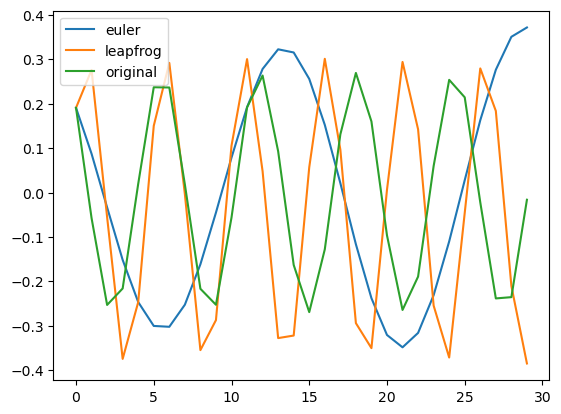

In [110]:
plt.plot(euler_trajectories[0, :, 0], label = "euler")
plt.plot(leapfrog_trajectories[0, :, 0], label = "leapfrog")
plt.plot(trajectories[0, :, 0], label = "original")
plt.legend()
plt.show()

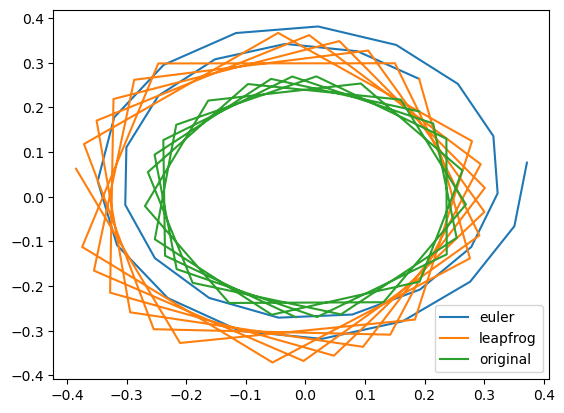

In [111]:
plt.plot(euler_trajectories[0, :, 0], euler_trajectories[0, :, 1], label = "euler")
plt.plot(leapfrog_trajectories[0, :, 0], leapfrog_trajectories[0, :, 1], label = "leapfrog")
plt.plot(trajectories[0, :, 0], trajectories[0, :, 1], label = "original")
plt.legend()
plt.show()

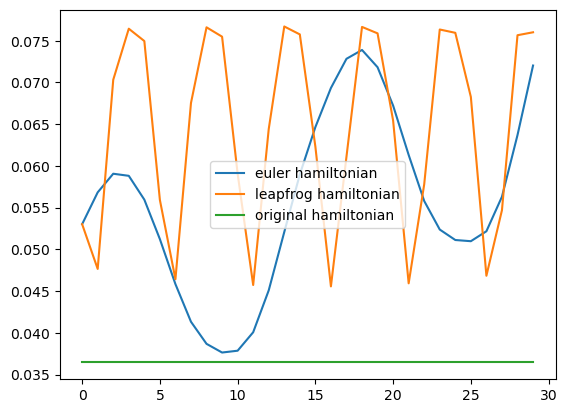

In [115]:
def hamiltonian(p, q):
    return 0.5 * (p**2 + q**2)

euler_h = hamiltonian(euler_trajectories[:, :, 0], euler_trajectories[:, :, 1])
leapfrog_h = hamiltonian(leapfrog_trajectories[:, :, 0], leapfrog_trajectories[:, :, 1])
original_h = hamiltonian(trajectories[:, :, 0], trajectories[:, :, 1])

plt.plot(euler_h[0, :], label = 'euler hamiltonian')
plt.plot(leapfrog_h[0, :], label = 'leapfrog hamiltonian')
plt.plot(original_h[0, :], label = 'original hamiltonian')
plt.legend()
plt.show()

In [120]:
class MyCustomFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        # Your forward pass implementation
        ctx.save_for_backward(input)  # Save tensors for backward pass if needed
        output = input * 2
        return output

    @staticmethod
    def backward(ctx, grad_output):
        # Your backward pass implementation
        input, = ctx.saved_tensors  # Retrieve saved tensors from forward pass
        grad_input = grad_output * 2  # Example gradient computation
        return grad_input

    def additional_method(self, x):
        # Additional custom method
        return x + 1

# Example usage
input = torch.tensor([1.0], requires_grad=True)
custom_function = MyCustomFunction.apply
output = custom_function(input)
print(output)
# output.backward()

# Creating an instance of MyCustomFunction
custom_function_instance = MyCustomFunction()

# Accessing additional custom method
result = custom_function_instance.additional_method(5)
print(result)  # Output: 6

tensor([2.], grad_fn=<MyCustomFunctionBackward>)
6


In [ ]:
class Hamiltonian_Adjoint(torch.autograd.Function):
    @staticmethod
    def forward(ctx, p_0, q_0, Func, T, dt, *adjoint_params):
        def dynamics_fn(x, Func):
            p = x[0]
            q = x[1]
            p.requires_grad_(True)
            q.requires_grad_(True)
            with torch.enable_grad():
                predicted_h = Func(p.unsqueeze(-1), q.unsqueeze(-1))
                p_grad, = grad(predicted_h.sum(), p, create_graph=True, allow_unused = True)
                q_grad, = grad(predicted_h.sum(), q, create_graph=True, allow_unused = True)
            return torch.stack([-q_grad, p_grad])

        def predictor(x, func, Func, dt):
            k1 = func(x, Func)
            k2 = func(x + 0.5 * dt * k1, Func)
            return x + dt * k2

        def corrector(x, x_, func, Func, dt, iter = 1):
            p = x_[0]
            q = x_[1]
            for i in range(iter):
                p_ = x[0] + 0.5 * dt * func(torch.stack([p, x[1]]), Func)[0]
                p = p_ + 0.5 * dt * func(torch.stack([p_, q]), Func)[0]
                q = x[1] + 0.5 * dt * (func(torch.stack([p_, x[1]]), Func)[1] + func(torch.stack([p_, q]), Func)[1])
            return torch.stack([p, q])

        def pc(x, Func, dt):
            x_ = predictor(x, dynamics_fn, Func, dt)
            return corrector(x, x_, dynamics_fn, Func, dt)
        
        trajectory = torch.zeros((p_0.shape[0], T, 2))
        trajectory[:, 0, 0] = p_0
        trajectory[:, 0, 1] = q_0
        p = p_0
        q = q_0
        for i in range(1, T):
            for _ in range(int(1/dt)):
                x = pc(torch.stack([p, q]), Func, dt)
                p = x[0]
                q = x[0]
            trajectory[:, i, 0] = p
            trajectory[:, i, 1] = q
        ctx.save_for_backward(trajectory.clone(), p_0.clone(), q_0.clone(), *adjoint_params)
        ctx.T = T
        ctx.dt = dt
        ctx.Func = Func
        return trajectory[:, :, 0], trajectory[:, :, 1]
    
    @staticmethod
    def backward(ctx, dldp, dldq):
        T = ctx.T
        dt = ctx.dt
        Func = ctx.Func
        trajectory, p_0, q_0, *adjoint_params = ctx.saved_tensors
        aug_state = [trajectory[:, -1, 0], trajectory[:, -1, 1], dldp[:, -1], dldq[:, -1]] #(p, q, adjp, adjq, theta)
        aug_state.extend([torch.zeros_like(param) for param in adjoint_params])
        
        def augmented_dynamics(y_aug):
            p = y_aug[0]
            q = y_aug[1]
            with torch.enable_grad():
                p = p.detach().requires_grad_(True)
                q = q.detach().requires_grad_(True)
                H = Func(p, q)
                _p = torch.as_strided(p, (), ())  # noqa
                _q = torch.as_strided(q, (), ())  # noqa
                _params = tuple(torch.as_strided(param, (), ()) for param in adjoint_params)
                # dhdp, dhdq = torch.autograd.grad(H.sum(), (p, q), allow_unused=True, retain_graph=True, create_graph=True)
                dhdp, = torch.autograd.grad(H.sum(), p, allow_unused = True, retain_graph = True, create_graph = True)
                dhdq, = torch.autograd.grad(H.sum(), q, allow_unused = True, retain_graph = True, create_graph = True)
                dhdpdq_1 = torch.autograd.grad(dhdp, q, -y_aug[3], allow_unused=True, retain_graph=True)
                dhdpdq_2 = torch.autograd.grad(dhdp, q, y_aug[2], allow_unused=True, retain_graph=True)
                dhdpdp = torch.autograd.grad(dhdp, p, -y_aug[3], allow_unused=True, retain_graph=True)
                dhdqdq = torch.autograd.grad(dhdq, q, y_aug[2], allow_unused=True, retain_graph=True)
                dhdpdw = torch.autograd.grad(dhdp, adjoint_params, -y_aug[3], allow_unused=True, retain_graph=True)
                dhdqdw = torch.autograd.grad(dhdq, adjoint_params, y_aug[2], allow_unused=True, retain_graph=True)

                dhdpdq_1 = [torch.zeros_like(p) if param is None else param for param in dhdpdq_1]
                dhdpdq_2 = [torch.zeros_like(q) if param is None else param for param in dhdpdq_2]
                dhdpdp = torch.zeros_like(p) if dhdpdp is None else dhdpdp
                dhdqdq = torch.zeros_like(q) if dhdqdq is None else dhdqdq
                dhdpdw = [torch.zeros_like(param) if vjp_param is None else vjp_param
                          for param, vjp_param in zip(adjoint_params, dhdpdw)]
                dhdqdw = [torch.zeros_like(param) if vjp_param is None else vjp_param
                          for param, vjp_param in zip(adjoint_params, dhdqdw)]
                dw = list(dhdp_param + dhdq_param for dhdp_param, dhdq_param in zip(dhdpdw, dhdqdw))
                f_p = -dhdq
                f_q = dhdp
                adjoint_p = dhdpdq_1[0] + dhdqdq[0]
                adjoint_q = dhdpdp[0] + dhdpdq_2[0]
                return f_p, f_q, adjoint_p, adjoint_q, *dw
            
        def corrector(x, x_, func, dt, iter = 1):
            p = x_[0]
            adj_p = x_[2]
            q = x_[1]
            adj_q = x[3]
            for i in range(iter):
                p_ = x[0] + 0.5 * dt * func([p] + x[1:])
                p = p_ + 0.5 * dt * func([p_]+x[1:])[0]
                adj_p = x[1] + 0.5 * dt * (func([p_, x[1]] + [x[2]] + x[3:])[2] + func([p_, x[1]] + [adj_p] + x[3:])[2])
                
            # p = x_[0]
            # q = x_[0]
            # for i in range(iter):
            #     p_ = x[0] + 0.5 * dt * func(torch.stack([p, x[1]]), Func)[0]
            #     p = p_ + 0.5 * dt * func(torch.stack([p_, q]), Func)[0]
            #     q = x[1] + 0.5 * dt * (func(torch.stack([p_, x[1]]), Func)[1] + func(torch.stack([p_, q]), Func)[1])
            # return torch.stack([p, q])
            
        
        def predictor(x, func, dt):
            k1 = func(x)
            k2 = func(x + 0.5 * dt * k1)
            return x + dt * k2
        
        def pc(x, augmented_dynamics, dt):
            x_ = predictor(x, augmented_dynamics, dt)
            return corrector(x, x_, augmented_dynamics, Func, dt)    
        
        for i in range(T-1, 0, -1):
            p_next, q_next, vjp_p_next, vjp_q_next, *dw_next = euler_solver(aug_state, augmented_dynamics, dt)
            aug_state[0] = trajectory[:, i-1, 0]
            aug_state[1] = trajectory[:, i-1, 1]
            aug_state[2] = vjp_p_next + dldp[:, i-1]
            aug_state[3] = vjp_q_next + dldq[:, i-1]
            aug_state[4:] = dw_next
        adj_p = aug_state[2]
        adj_q = aug_state[3]
        adj_params = aug_state[4:]
        return None, adj_p, adj_q, None, None, None, None, None, None, *adj_params

In [ ]:
def hnn_adjoint(func, x, T, dt):
    adjoint_params = tuple(list(func.parameters()))
    adjoint_params = tuple(p for p in adjoint_params if p.requires_grad)
    p, q = Hamiltonian_Adjoint.apply(x[0], x[1], func, T, dt, *adjoint_params)
    return p, q

class Symplectic_HNN(nn.Module):
    def __init__(self, n_hidden, input_size, T, dt):
        super(Symplectic_HNN, self).__init__()
        self.func = MLP1H_Separable_Hamilt(n_hidden = 256, input_size = 1)
        self.T = T
        self.dt = dt
        self.dim = input_size
        
    def forward(self, x):
        p, q = hnn_adjoint(self.func, x, self.T, self.dt)
        # p, q = Hamiltonian_Adjoint.apply(self.integrator, p_0, q_0, self.func, self.T, self.dt, self.volatile, self.device, self.dim)
        return torch.cat([p, q], axis = 1)

In [53]:
t0 = 0
t1 = 30
dt = 0.1
# num_steps = int((t1-t0)/dt)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MLP2H_Separable_Hamilt(n_hidden = 256, input_size = 1).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)
train_mass_spring = HarmonicOscillatorDataset("leapfrog_mass_spring_30_train.npy")
val_mass_spring = HarmonicOscillatorDataset("leapfrog_mass_spring_30_val.npy")
# Create a DataLoader for the dataset
data_loader = DataLoader(train_mass_spring, batch_size=32, shuffle=True)
val_loader = DataLoader(val_mass_spring, batch_size=32, shuffle=False)

num_epochs = 10
num_steps = int(1/dt)
best_val_loss = float('inf')
best_model_path = 'best_model.pt'

train_loss = []
val_loss = []

for epoch in tqdm(range(num_epochs)):
    loss_epoch = []
    # Training phase
    model.train()
    total_loss = 0
    for batch in data_loader:
        optimizer.zero_grad()
        p_batch, q_batch, _ = batch
        p0_batch = p_batch[:, 0].to(device)
        q0_batch = q_batch[:, 1].to(device)
        simulated_trajectory = torch.zeros((p0_batch.shape[0], t1, 2)).to(device)
        p = p0_batch
        q = q0_batch
        simulated_trajectory[:, 0, 0] = p
        simulated_trajectory[:, 0, 1] = q
        p.requires_grad_(True)
        q.requires_grad_(True)
        for time in range(1, t1):
            for _ in range(num_steps):
                predicted_h = model(p.unsqueeze(-1), q.unsqueeze(-1))
                p_grad, = grad(predicted_h.sum(), p, create_graph=True, allow_unused=True)
                q_grad, = grad(predicted_h.sum(), q, create_graph=True, allow_unused=True)
                p = p - dt*q_grad
                q = q + dt*p_grad
            simulated_trajectory[:, time, 0] = p
            simulated_trajectory[:, time, 1] = q 
        trajectory = torch.stack([p_batch, q_batch], axis=2).to(device)
        loss = criterion(trajectory, simulated_trajectory)
        loss.backward()
        optimizer.step()
        loss_epoch.append(loss.item())
    
    avg_train_loss = sum(loss_epoch)/len(loss_epoch)
    train_loss.append(avg_train_loss)
    # scheduler.step()

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss_epoch = []
    # with torch.no_grad():
    for batch in val_loader:
        p_batch, q_batch, _ = batch
        p0_batch = p_batch[:, 0].to(device)
        q0_batch = q_batch[:, 1].to(device)
        simulated_trajectory = torch.zeros((p0_batch.shape[0], t1, 2)).to(device)
        p = p0_batch
        q = q0_batch
        simulated_trajectory[:, 0, 0] = p
        simulated_trajectory[:, 0, 1] = q
        p.requires_grad_(True)
        q.requires_grad_(True)
        for time in range(1, t1):
            for _ in range(num_steps):
                predicted_h = model(p.unsqueeze(-1), q.unsqueeze(-1))
                p_grad, = grad(predicted_h.sum(), p, create_graph=True, allow_unused=True)
                q_grad, = grad(predicted_h.sum(), q, create_graph=True, allow_unused=True)
                p = p - dt*q_grad
                q = q + dt*p_grad
            simulated_trajectory[:, time, 0] = p
            simulated_trajectory[:, time, 1] = q   
        trajectory = torch.stack([p_batch, q_batch], axis=2).to(device)
        val_loss_epoch.append(criterion(trajectory, simulated_trajectory).item())
    avg_val_loss = sum(val_loss_epoch)/len(val_loss_epoch)
    val_loss.append(avg_val_loss)
    # Check if the validation loss is the lowest seen so far
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        # Save the model
        torch.save(model.state_dict(), best_model_path)
    # Print average losses for this epoch
    print(f"Epoch {epoch+1}, Average Train Loss: {avg_train_loss}, Average Val Loss: {avg_val_loss}")

 10%|████▍                                       | 1/10 [01:07<10:09, 67.67s/it]

Epoch 1, Average Train Loss: 13.995308846235275, Average Val Loss: 3.2788940593600273


 20%|████████▊                                   | 2/10 [02:14<08:58, 67.25s/it]

Epoch 2, Average Train Loss: 2.4610523618757725, Average Val Loss: 4.4844062104821205


 30%|█████████████▏                              | 3/10 [03:22<07:53, 67.68s/it]

Epoch 3, Average Train Loss: 1.5111193042248487, Average Val Loss: 0.7565921656787395


 40%|█████████████████▌                          | 4/10 [04:30<06:46, 67.69s/it]

Epoch 4, Average Train Loss: 0.6539791068062186, Average Val Loss: 0.683568156324327


 50%|██████████████████████                      | 5/10 [05:40<05:42, 68.55s/it]

Epoch 5, Average Train Loss: 0.7523618116974831, Average Val Loss: 0.7576730810105801


 60%|██████████████████████████▍                 | 6/10 [06:48<04:33, 68.37s/it]

Epoch 6, Average Train Loss: 0.6722747571766376, Average Val Loss: 0.5849876664578915


 70%|██████████████████████████████▊             | 7/10 [07:56<03:24, 68.19s/it]

Epoch 7, Average Train Loss: 0.5644888263195753, Average Val Loss: 0.5403375830501318


 80%|███████████████████████████████████▏        | 8/10 [09:05<02:16, 68.39s/it]

Epoch 8, Average Train Loss: 0.5314059406518936, Average Val Loss: 0.5152271343395114


 90%|███████████████████████████████████████▌    | 9/10 [10:13<01:08, 68.36s/it]

Epoch 9, Average Train Loss: 0.5108768651261926, Average Val Loss: 0.4937669401988387


100%|███████████████████████████████████████████| 10/10 [11:22<00:00, 68.27s/it]

Epoch 10, Average Train Loss: 0.48781509418040514, Average Val Loss: 0.48375971801579


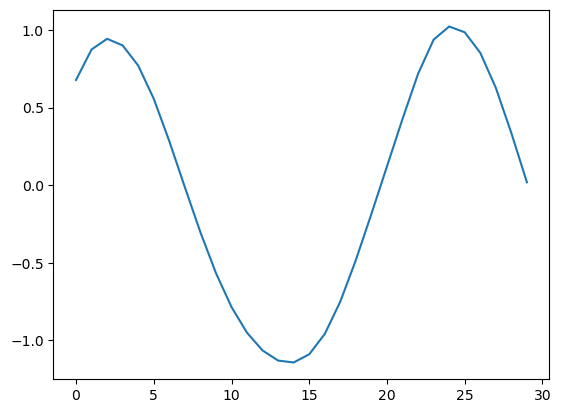

In [54]:
plt.plot(simulated_trajectory[0,:,0].detach().numpy())

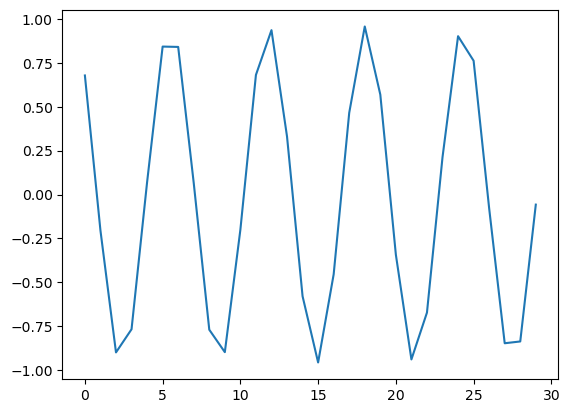

In [55]:
plt.plot(trajectory[0,:,0].detach().numpy())

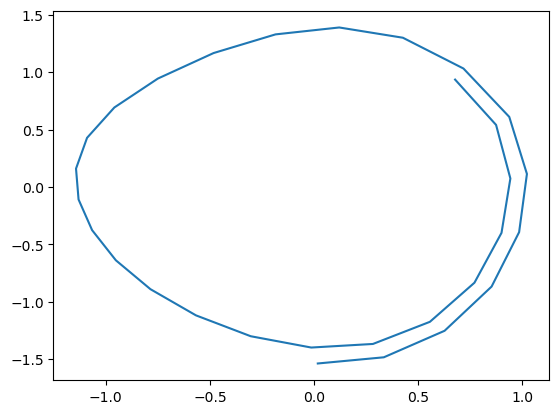

In [56]:
plt.plot(simulated_trajectory[0,:,0].detach().numpy(), simulated_trajectory[0,:,1].detach().numpy())

In [57]:
t0 = 0
t1 = 30
dt = 0.1
# num_steps = int((t1-t0)/dt)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MLP2H_Separable_Hamilt(n_hidden = 256, input_size = 1).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# scheduler = StepLR(optimizer, step_size=2, gamma=0.1)
train_mass_spring = HarmonicOscillatorDataset("leapfrog_mass_spring_30_train.npy")
val_mass_spring = HarmonicOscillatorDataset("leapfrog_mass_spring_30_val.npy")
# Create a DataLoader for the dataset
data_loader = DataLoader(train_mass_spring, batch_size=32, shuffle=True)
val_loader = DataLoader(val_mass_spring, batch_size=32, shuffle=False)

num_epochs = 10
num_steps = int(1/dt)
best_val_loss = float('inf')
best_model_path = 'best_model.pt'

train_loss = []
val_loss = []

for epoch in tqdm(range(num_epochs)):
    loss_epoch = []
    # Training phase
    model.train()
    total_loss = 0
    for batch in data_loader:
        optimizer.zero_grad()
        p_batch, q_batch, _ = batch
        p0_batch = p_batch[:, 0].to(device)
        q0_batch = q_batch[:, 1].to(device)
        simulated_trajectory = torch.zeros((p0_batch.shape[0], t1, 2)).to(device)
        p = p0_batch
        q = q0_batch
        simulated_trajectory[:, 0, 0] = p
        simulated_trajectory[:, 0, 1] = q
        p.requires_grad_(True)
        q.requires_grad_(True)
        for time in range(1, t1):
            for _ in range(num_steps):
                predicted_h = model(p.unsqueeze(-1), q.unsqueeze(-1))
                # p_grad, = grad(predicted_h.sum(), p, create_graph=True, allow_unused=True)
                q_grad, = grad(predicted_h.sum(), q, create_graph=True, allow_unused=True)
                # p = p - dt*q_grad
                # q = q + dt*p_grad
                p = p - 0.5 * dt * q_grad
                predicted_h = model(p.unsqueeze(-1), q.unsqueeze(-1))
                p_grad, = grad(predicted_h.sum(), p, create_graph=True, allow_unused=True)
                q = q + dt * p_grad
                predicted_h = model(p.unsqueeze(-1), q.unsqueeze(-1))
                q_grad, = grad(predicted_h.sum(), q, create_graph=True, allow_unused=True)
                p = p - 0.5 * dt * q_grad
            simulated_trajectory[:, time, 0] = p
            simulated_trajectory[:, time, 1] = q   
        trajectory = torch.stack([p_batch, q_batch], axis=2).to(device)
        loss = criterion(trajectory, simulated_trajectory)
        loss.backward()
        optimizer.step()
        loss_epoch.append(loss.item())
    avg_train_loss = sum(loss_epoch)/len(loss_epoch)
    train_loss.append(avg_train_loss)
    # scheduler.step()

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss_epoch = []
    # with torch.no_grad():
    for batch in val_loader:
        p_batch, q_batch, _ = batch
        p0_batch = p_batch[:, 0].to(device)
        q0_batch = q_batch[:, 1].to(device)
        simulated_trajectory = torch.zeros((p0_batch.shape[0], t1, 2)).to(device)
        p = p0_batch
        q = q0_batch
        simulated_trajectory[:, 0, 0] = p
        simulated_trajectory[:, 0, 1] = q
        p.requires_grad_(True)
        q.requires_grad_(True)
        for time in range(1, t1):
            for _ in range(num_steps):
                predicted_h = model(p.unsqueeze(-1), q.unsqueeze(-1))
                # p_grad, = grad(predicted_h.sum(), p, create_graph=True, allow_unused=True)
                q_grad, = grad(predicted_h.sum(), q, create_graph=True, allow_unused=True)
                # p = p - dt*q_grad
                # q = q + dt*p_grad
                p = p - 0.5 * dt * q_grad
                predicted_h = model(p.unsqueeze(-1), q.unsqueeze(-1))
                p_grad, = grad(predicted_h.sum(), p, create_graph=True, allow_unused=True)
                q = q + dt * p_grad
                predicted_h = model(p.unsqueeze(-1), q.unsqueeze(-1))
                q_grad, = grad(predicted_h.sum(), q, create_graph=True, allow_unused=True)
                p = p - 0.5 * dt * q_grad
            simulated_trajectory[:, time, 0] = p
            simulated_trajectory[:, time, 1] = q   
        trajectory = torch.stack([p_batch, q_batch], axis=2).to(device)
        val_loss_epoch.append(criterion(trajectory, simulated_trajectory).item())
    avg_val_loss = sum(val_loss_epoch)/len(val_loss_epoch)
    val_loss.append(avg_val_loss)
    # Check if the validation loss is the lowest seen so far
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        # Save the model
        torch.save(model.state_dict(), best_model_path)
    # Print average losses for this epoch
    print(f"Epoch {epoch+1}, Average Train Loss: {avg_train_loss}, Average Val Loss: {avg_val_loss}")

 10%|████▎                                      | 1/10 [03:16<29:24, 196.07s/it]

Epoch 1, Average Train Loss: 10.18329731747508, Average Val Loss: 2.4733119122684


 20%|████████▌                                  | 2/10 [06:35<26:24, 198.05s/it]

Epoch 2, Average Train Loss: 22.347107514739037, Average Val Loss: 57.062084555625916


 30%|████████████▉                              | 3/10 [09:55<23:13, 199.09s/it]

Epoch 3, Average Train Loss: 21.584532603621483, Average Val Loss: 3.054332211613655


 40%|█████████████████▏                         | 4/10 [13:11<19:46, 197.74s/it]

Epoch 4, Average Train Loss: 1.040587448514998, Average Val Loss: 0.6447579329833388


 50%|█████████████████████▌                     | 5/10 [16:29<16:28, 197.66s/it]

Epoch 5, Average Train Loss: 0.5751782674342394, Average Val Loss: 0.5355288712307811


 60%|█████████████████████████▊                 | 6/10 [19:43<13:06, 196.72s/it]

Epoch 6, Average Train Loss: 0.5317740123718977, Average Val Loss: 0.5226818891242146


 70%|██████████████████████████████             | 7/10 [22:54<09:43, 194.60s/it]

Epoch 7, Average Train Loss: 0.5219547133892775, Average Val Loss: 0.5146452253684402


 80%|██████████████████████████████████▍        | 8/10 [26:10<06:30, 195.27s/it]

Epoch 8, Average Train Loss: 0.5123713109642267, Average Val Loss: 0.5080634979531169


 90%|██████████████████████████████████████▋    | 9/10 [29:19<03:13, 193.05s/it]

Epoch 9, Average Train Loss: 0.5112012028694153, Average Val Loss: 0.4989651022478938


100%|██████████████████████████████████████████| 10/10 [32:29<00:00, 194.93s/it]

Epoch 10, Average Train Loss: 0.4940206725150347, Average Val Loss: 0.48755269031971693


In [22]:
print(simulated_trajectory[0, :, 0])
print(simulated_trajectory[0, :, 1])
print(trajectory[0, :, 0])
print(trajectory[0, :, 1])

tensor([0.6780, 0.6515, 0.6237, 0.5952, 0.5670, 0.5397, 0.5139, 0.4903, 0.4692,
        0.4509, 0.4357, 0.4237, 0.4149, 0.4094, 0.4071, 0.4079, 0.4118, 0.4186,
        0.4282, 0.4405, 0.4553, 0.4724, 0.4918, 0.5133, 0.5369, 0.5624, 0.5900,
        0.6197, 0.6514, 0.6852], grad_fn=<SelectBackward0>)
tensor([ 0.9368,  0.8707,  0.8054,  0.7411,  0.6782,  0.6166,  0.5565,  0.4980,
         0.4409,  0.3852,  0.3308,  0.2774,  0.2248,  0.1729,  0.1212,  0.0696,
         0.0178, -0.0344, -0.0873, -0.1411, -0.1958, -0.2518, -0.3090, -0.3676,
        -0.4276, -0.4890, -0.5517, -0.6157, -0.6809, -0.7472],
       grad_fn=<SelectBackward0>)
tensor([ 0.6780, -0.2042, -0.8986, -0.7669,  0.0699,  0.8424,  0.8404,  0.0657,
        -0.7694, -0.8971, -0.2000,  0.6810,  0.9359,  0.3304, -0.5789, -0.9559,
        -0.4541,  0.4652,  0.9568,  0.5687, -0.3423, -0.9386, -0.6719,  0.2125,
         0.9015,  0.7617, -0.0784, -0.8465, -0.8363, -0.0572])
tensor([ 0.6780,  0.9368,  0.3343, -0.5755, -0.9562, -0.4578

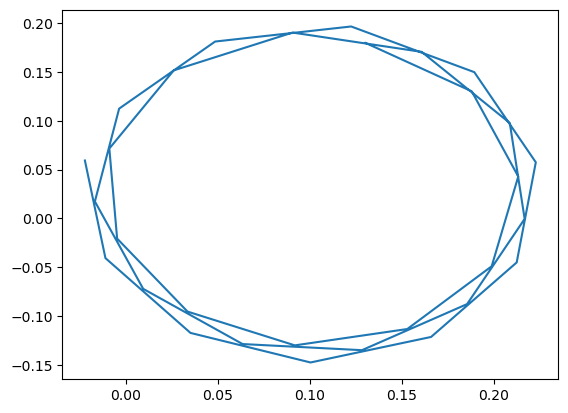

In [58]:
plt.plot(simulated_trajectory[7, :, 0].detach().numpy(), simulated_trajectory[7, :, 1].detach().numpy())

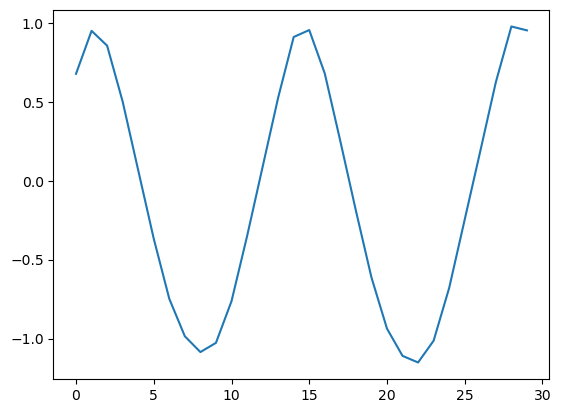

In [59]:
plt.plot(simulated_trajectory[0, :, 0].detach().numpy())

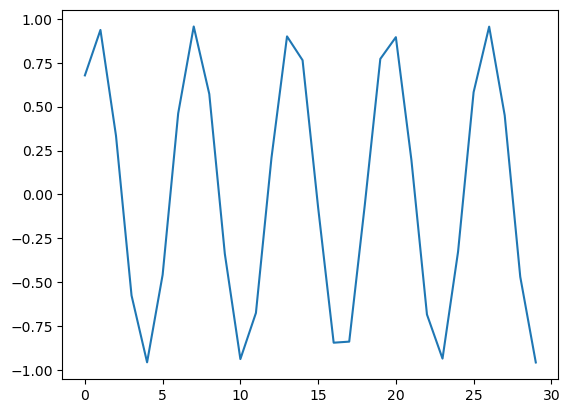

In [60]:
plt.plot(trajectory[0, :, 1].detach().numpy())

In [125]:
trajectory[1, :, 1]

tensor([ 0.3832,  0.5295,  0.1890, -0.3253, -0.5405, -0.2588,  0.2609,  0.5407,
         0.3234, -0.1912, -0.5300, -0.3815,  0.1178,  0.5088,  0.4320, -0.0419,
        -0.4773, -0.4739, -0.0347,  0.4363,  0.5062,  0.1107, -0.3866, -0.5285,
        -0.1845,  0.3291,  0.5401,  0.2545, -0.2651, -0.5410])

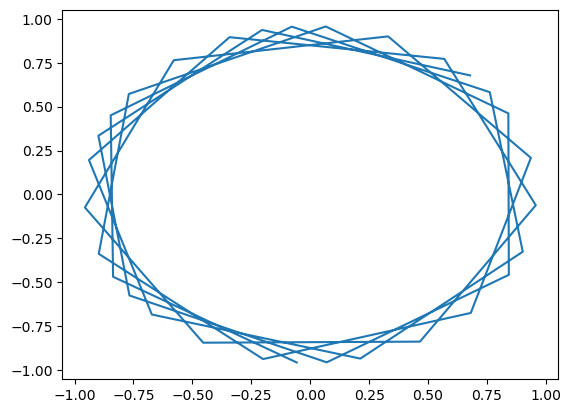

In [117]:
plt.plot(trajectory[0, :, 0].detach().numpy(), trajectory[0, :, 1].detach().numpy())

In [543]:
class Hamiltonian_Adjoint(torch.autograd.Function):
    @staticmethod
    def forward(ctx, p_0, q_0, Func, T, dt, *adjoint_params):
        def dynamics_fn(x, Func):
            p = x[0]
            q = x[1]
            p.requires_grad_(True)
            q.requires_grad_(True)
            with torch.enable_grad():
                predicted_h = Func(p.unsqueeze(-1), q.unsqueeze(-1))
                p_grad, = grad(predicted_h.sum(), p, create_graph=True, allow_unused = True)
                q_grad, = grad(predicted_h.sum(), q, create_graph=True, allow_unused = True)
            return torch.stack([-q_grad, p_grad])

        def predictor(x, func, Func, dt):
            k1 = func(x, Func)
            k2 = func(x + 0.5 * dt * k1, Func)
            return x + dt * k2

        def corrector(x, x_, func, Func, dt, iter = 1):
            p = x_[0]
            q = x_[1]
            for i in range(iter):
                p_ = x[0] + 0.5 * dt * func(torch.stack([p, x[1]]), Func)[0]
                p = p_ + 0.5 * dt * func(torch.stack([p_, q]), Func)[0]
                q = x[1] + 0.5 * dt * (func(torch.stack([p_, x[1]]), Func)[1] + func(torch.stack([p_, q]), Func)[1])
            return torch.stack([p, q])

        def pc(x, Func, dt):
            x_ = predictor(x, dynamics_fn, Func, dt)
            return corrector(x, x_, dynamics_fn, Func, dt)
        
        trajectory = torch.zeros((p_0.shape[0], T, 2))
        trajectory[:, 0, 0] = p_0
        trajectory[:, 0, 1] = q_0
        p = p_0
        q = q_0
        for i in range(1, T):
            for _ in range(int(1/dt)):
                x = pc(torch.stack([p, q]), Func, dt)
                p = x[0]
                q = x[0]
            trajectory[:, i, 0] = p
            trajectory[:, i, 1] = q
        ctx.save_for_backward(trajectory.clone(), p_0.clone(), q_0.clone(), *adjoint_params)
        ctx.T = T
        ctx.dt = dt
        ctx.Func = Func
        return trajectory[:, :, 0], trajectory[:, :, 1]
    
    @staticmethod
    def backward(ctx, dldp, dldq):
        T = ctx.T
        dt = ctx.dt
        Func = ctx.Func
        trajectory, p_0, q_0, *adjoint_params = ctx.saved_tensors
        aug_state = [trajectory[:, -1, 0], trajectory[:, -1, 1], dldp[:, -1], dldq[:, -1]] #(p, q, adjp, adjq, theta)
        aug_state.extend([torch.zeros_like(param) for param in adjoint_params])
        
        def augmented_dynamics(y_aug):
            p = y_aug[0]
            q = y_aug[1]
            with torch.enable_grad():
                p = p.detach().requires_grad_(True)
                q = q.detach().requires_grad_(True)
                H = Func(p, q)
                _p = torch.as_strided(p, (), ())  # noqa
                _q = torch.as_strided(q, (), ())  # noqa
                _params = tuple(torch.as_strided(param, (), ()) for param in adjoint_params)
                # dhdp, dhdq = torch.autograd.grad(H.sum(), (p, q), allow_unused=True, retain_graph=True, create_graph=True)
                dhdp, = torch.autograd.grad(H.sum(), p, allow_unused = True, retain_graph = True, create_graph = True)
                dhdq, = torch.autograd.grad(H.sum(), q, allow_unused = True, retain_graph = True, create_graph = True)
                dhdpdq_1 = torch.autograd.grad(dhdp, q, -y_aug[3], allow_unused=True, retain_graph=True)
                dhdpdq_2 = torch.autograd.grad(dhdp, q, y_aug[2], allow_unused=True, retain_graph=True)
                dhdpdp = torch.autograd.grad(dhdp, p, -y_aug[3], allow_unused=True, retain_graph=True)
                dhdqdq = torch.autograd.grad(dhdq, q, y_aug[2], allow_unused=True, retain_graph=True)
                dhdpdw = torch.autograd.grad(dhdp, adjoint_params, -y_aug[3], allow_unused=True, retain_graph=True)
                dhdqdw = torch.autograd.grad(dhdq, adjoint_params, y_aug[2], allow_unused=True, retain_graph=True)

                dhdpdq_1 = [torch.zeros_like(p) if param is None else param for param in dhdpdq_1]
                dhdpdq_2 = [torch.zeros_like(q) if param is None else param for param in dhdpdq_2]
                dhdpdp = torch.zeros_like(p) if dhdpdp is None else dhdpdp
                dhdqdq = torch.zeros_like(q) if dhdqdq is None else dhdqdq
                dhdpdw = [torch.zeros_like(param) if vjp_param is None else vjp_param
                          for param, vjp_param in zip(adjoint_params, dhdpdw)]
                dhdqdw = [torch.zeros_like(param) if vjp_param is None else vjp_param
                          for param, vjp_param in zip(adjoint_params, dhdqdw)]
                dw = list(dhdp_param + dhdq_param for dhdp_param, dhdq_param in zip(dhdpdw, dhdqdw))
                f_p = -dhdq
                f_q = dhdp
                adjoint_p = dhdpdq_1[0] + dhdqdq[0]
                adjoint_q = dhdpdp[0] + dhdpdq_2[0]
                return f_p, f_q, adjoint_p, adjoint_q, *dw
            
        def corrector(x, x_, func, dt, iter = 1):
            p = x_[0]
            adj_p = x_[2]
            q = x_[1]
            adj_q = x[3]
            for i in range(iter):
                p_ = x[0] + 0.5 * dt * func([p] + x[1:])
                p = p_ + 0.5 * dt * func([p_]+x[1:])[0]
                adj_p = x[1] + 0.5 * dt * (func([p_, x[1]] + [x[2]] + x[3:])[2] + func([p_, x[1]] + [adj_p] + x[3:])[2])
                
            # p = x_[0]
            # q = x_[0]
            # for i in range(iter):
            #     p_ = x[0] + 0.5 * dt * func(torch.stack([p, x[1]]), Func)[0]
            #     p = p_ + 0.5 * dt * func(torch.stack([p_, q]), Func)[0]
            #     q = x[1] + 0.5 * dt * (func(torch.stack([p_, x[1]]), Func)[1] + func(torch.stack([p_, q]), Func)[1])
            # return torch.stack([p, q])
            
        
        def predictor(x, func, dt):
            k1 = func(x)
            k2 = func(x + 0.5 * dt * k1)
            return x + dt * k2
        
        def pc(x, augmented_dynamics, dt):
            x_ = predictor(x, augmented_dynamics, dt)
            return corrector(x, x_, augmented_dynamics, Func, dt)    
        
        for i in range(T-1, 0, -1):
            p_next, q_next, vjp_p_next, vjp_q_next, *dw_next = euler_solver(aug_state, augmented_dynamics, dt)
            aug_state[0] = trajectory[:, i-1, 0]
            aug_state[1] = trajectory[:, i-1, 1]
            aug_state[2] = vjp_p_next + dldp[:, i-1]
            aug_state[3] = vjp_q_next + dldq[:, i-1]
            aug_state[4:] = dw_next
        adj_p = aug_state[2]
        adj_q = aug_state[3]
        adj_params = aug_state[4:]
        return None, adj_p, adj_q, None, None, None, None, None, None, *adj_params

In [544]:
def hnn_adjoint(func, x, T, dt):
    adjoint_params = tuple(list(func.parameters()))
    adjoint_params = tuple(p for p in adjoint_params if p.requires_grad)
    p, q = Hamiltonian_Adjoint.apply(x[0], x[1], func, T, dt, *adjoint_params)
    return p, q

class Symplectic_HNN(nn.Module):
    def __init__(self, n_hidden, input_size, T, dt):
        super(Symplectic_HNN, self).__init__()
        self.func = MLP1H_Separable_Hamilt(n_hidden = 256, input_size = 1)
        self.T = T
        self.dt = dt
        self.dim = input_size
        
    def forward(self, x):
        p, q = hnn_adjoint(self.func, x, self.T, self.dt)
        # p, q = Hamiltonian_Adjoint.apply(self.integrator, p_0, q_0, self.func, self.T, self.dt, self.volatile, self.device, self.dim)
        return torch.cat([p, q], axis = 1)

In [545]:
t0 = 0
t1 = 30
dt = 0.1
# num_steps = int((t1-t0)/dt)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Symplectic_HNN(n_hidden = 256, input_size = 1, T = t1, dt = dt)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_mass_spring = HarmonicOscillatorDataset("leapfrog_mass_spring_30_train.npy")
val_mass_spring = HarmonicOscillatorDataset("leapfrog_mass_spring_30_val.npy")
# Create a DataLoader for the dataset
data_loader = DataLoader(train_mass_spring, batch_size=32, shuffle=True)
val_loader = DataLoader(val_mass_spring, batch_size=32, shuffle=False)

num_epochs = 10
num_steps = int(1/dt)
best_val_loss = float('inf')
best_model_path = 'best_model.pt'

train_loss = []
val_loss = []

for epoch in tqdm(range(num_epochs)):
    loss_epoch = []
    # Training phase
    model.train()
    total_loss = 0
    for batch in data_loader:
        optimizer.zero_grad()
        p_batch, q_batch, _ = batch
        p0_batch = p_batch[:, 0].to(device)
        q0_batch = q_batch[:, 0].to(device)
        p = p0_batch
        q = q0_batch
        simulated_trajectory = model(torch.stack([p, q]))
        trajectory = torch.stack([p_batch, q_batch], axis=2).to(device)
        trajectory = trajectory.view(trajectory.size(0), -1).to(device)
        loss = criterion(trajectory, simulated_trajectory)
        loss.backward()
        optimizer.step()
        loss_epoch.append(loss.item())
    avg_train_loss = sum(loss_epoch)/len(loss_epoch)
    train_loss.append(avg_train_loss)


  0%|                                                    | 0/10 [00:03<?, ?it/s]

p torch.Size([32])
q torch.Size([32])
adjoint p torch.Size([32])
adjoint q torch.Size([32])


RuntimeError: function Hamiltonian_AdjointBackward returned an incorrect number of gradients (expected 13, got 1)

In [421]:
def hamiltonian_dynamics(x):
    return np.array([-x[1], x[0]])

def leapfrog_step(x, func, dt):
    # Half-step update for momentum
    x[0] += 0.5 * func(x)[0] * dt
    # Full-step update for position
    x[1] += func(x)[1] * dt
    # Half-step update for momentum
    x[0] += 0.5 * func(x)[0] * dt
    return x

trajectory = np.load("mass_spring_30.npy")
leapfrog_trajectory = np.zeros(dataset.shape)
timesteps = dataset.shape[1]
dt = 0.001
for sample in tqdm(range(dataset.shape[0])):
    leapfrog_trajectory[sample, 0, :] = trajectory[sample, 0, :]
    p = leapfrog_trajectory[sample, 0, 0]
    q = leapfrog_trajectory[sample, 0, 1]
    for time in range(1, timesteps):
        num_steps = int(1/dt)
        for _ in range(num_steps):
            x = leapfrog_step(np.array([p, q]), hamiltonian_dynamics, dt)
            p = x[0]
            q = x[1]
        leapfrog_trajectory[sample, time, 0] = p
        leapfrog_trajectory[sample, time, 1] = q
        leapfrog_trajectory[sample, time, 2] = hamiltonian(p, q)

100%|███████████████████████████████████████| 1000/1000 [01:34<00:00, 10.56it/s]


In [422]:
def hamiltonian_dynamics(x):
    return np.array([-x[1], x[0]])

def predictor_step(y, h, func):
    k1 = func(y)
    k2 = func(y + 0.5 * h * k1)
    return y + h * k2

def corrector_step(x, x_, func, dt, iter = 1):
    p = x_[0]
    q = x_[1]
    for i in range(iter):
        p_next = (x[0] + p)/2
        coor1 = np.array([p_next, x[1]])
        coor2 = np.array([p_next, q])
        p = x[0] + dt*0.5*(func(coor1)[0] + func(coor2)[0])
        q = x[1] + dt*0.5*(func(coor1)[1] + func(coor2)[1])
    return np.array([p, q])
    
def predictor_corrector(x, func, dt, iter = 1):
    x_ = predictor_step(x, dt, func)
    x_next = corrector_step(x, x_, func, dt, iter)
    return x_next

trajectory = np.load("mass_spring_30.npy")
pc_trajectory = np.zeros(dataset.shape)
timesteps = dataset.shape[1]
dt = 0.001
for sample in tqdm(range(dataset.shape[0])):
    pc_trajectory[sample, 0, :] = trajectory[sample, 0, :]
    p = pc_trajectory[sample, 0, 0]
    q = pc_trajectory[sample, 0, 1]
    for time in range(1, timesteps):
        num_steps = int(1/dt)
        for _ in range(num_steps):
            x = predictor_corrector(np.array([p, q]), hamiltonian_dynamics, dt, iter = 1)
            p = x[0]
            q = x[1]
        pc_trajectory[sample, time, 0] = p
        pc_trajectory[sample, time, 1] = q
        pc_trajectory[sample, time, 2] = hamiltonian(p, q)

100%|███████████████████████████████████████| 1000/1000 [04:57<00:00,  3.37it/s]


In [423]:
def l2_error(arr1, arr2, index):
    return np.mean(np.linalg.norm(arr1[:, :, index] - arr2[:, :, index], axis = 1))
print("euler p")
print(l2_error(trajectory, euler_trajectory, 0))
print("leapfrog p")
print(l2_error(trajectory, leapfrog_trajectory, 0))
print("pc p")
print(l2_error(trajectory, pc_trajectory, 0))

print("euler q")
print(l2_error(trajectory, euler_trajectory, 1))
print("leapfrog q")
print(l2_error(trajectory, leapfrog_trajectory, 1))
print("pc q")
print(l2_error(trajectory, pc_trajectory, 1))

print("euler h")
print(l2_error(trajectory, euler_trajectory, 2))
print("leapfrog h")
print(l2_error(trajectory, leapfrog_trajectory, 2))
print("pc h")
print(l2_error(trajectory, pc_trajectory, 2))


euler p
0.03755705738459105
leapfrog p
3.1942638093784077e-06
pc p
6.370250780476703e-06
euler q
0.038434454737622234
leapfrog q
3.1051935381086955e-06
pc q
6.225095297315483e-06
euler h
0.06633372387758589
leapfrog h
4.551315124276567e-07
pc h
1.640055396245422e-08


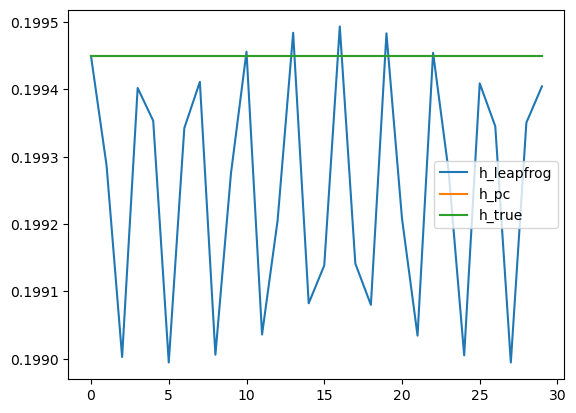

In [371]:
# plt.plot(euler_trajectory[0, :, 2], label = "h_euler")
plt.plot(leapfrog_trajectory[0, :, 2], label = "h_leapfrog")
plt.plot(pc_trajectory[0, :, 2], label = "h_pc")
plt.plot(trajectory[0, :, 2], label = "h_true")
plt.legend()
plt.show()

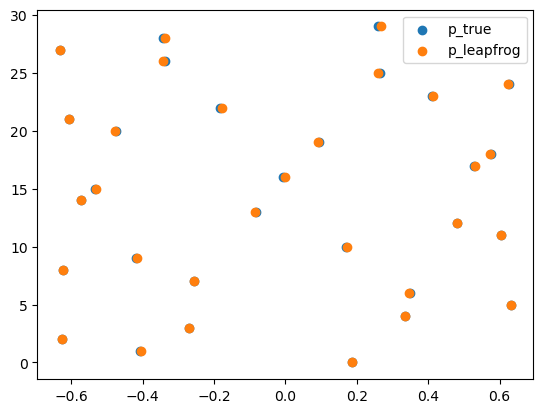

In [372]:
plt.scatter(trajectory[0, :, 0], list(range(30)), label = "p_true")
# plt.scatter(pc_trajectory[0, :, 0], list(range(30)), label = "p_pc")
plt.scatter(leapfrog_trajectory[0, :, 0], list(range(30)), label = "p_leapfrog")
plt.legend()

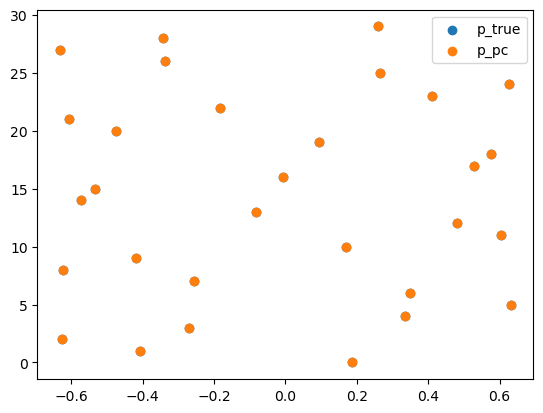

In [373]:
plt.scatter(trajectory[0, :, 0], list(range(30)), label = "p_true")
plt.scatter(pc_trajectory[0, :, 0], list(range(30)), label = "p_pc")
# plt.scatter(leapfrog_trajectory[0, :, 0], list(range(30)), label = "p_leapfrog")
plt.legend()

In [177]:
# Simulation parameters
num_samples = 1000
t0 = 0
t1 = 10
dt = 0.01
num_steps = int((t1-t0)/dt)

# Mass and spring constant
m = 1.0
k = 1.0

# Initialize array to store the dataset
dataset = np.zeros((num_samples, num_steps, 3))  # 3 for p, q, and h

# Perform simulation for each sample using Euler method
for sample in range(num_samples):
    # Initial conditions with random perturbations
    p0 = np.random.uniform(-1, 1)  # initial momentum with random perturbation
    q0 = np.random.uniform(0.5, 1.5)  # initial position with random perturbation
    
    # Initialize arrays to store results for this sample
    p_values = np.zeros(num_steps)
    q_values = np.zeros(num_steps)
    h_values = np.zeros(num_steps)
    
    # Perform simulation using Euler method
    p = p0
    q = q0
    for i in range(num_steps):
        p_values[i] = p
        q_values[i] = q
        h_values[i] = hamiltonian(p, q, m, k)
        # Update momentum and position using Euler method
        p -= dt * (k*q)
        q += dt * (p/m)
    
    # Store the results for this sample in the dataset
    dataset[sample, :, 0] = p_values
    dataset[sample, :, 1] = q_values
    dataset[sample, :, 2] = h_values

In [178]:
dataset.shape

(1000, 1000, 3)

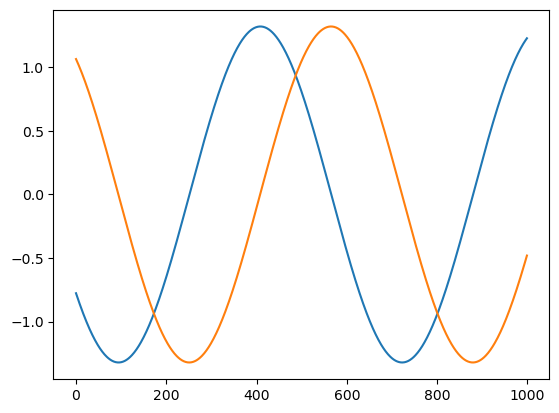

In [179]:
plt.plot(dataset[0, :, 0], label = "p")
plt.plot(dataset[0, :, 1], label = "q")
plt.show()

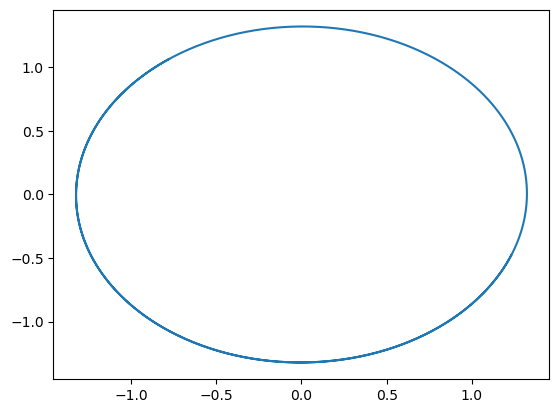

In [180]:
plt.plot(dataset[0, :, 0], dataset[0, :, 1])

In [181]:
dataset.shape[1]/t1

100.0

In [182]:
final_dataset = dataset[:, ::int(dataset.shape[1]/t1), :]
final_dataset.shape

(1000, 10, 3)

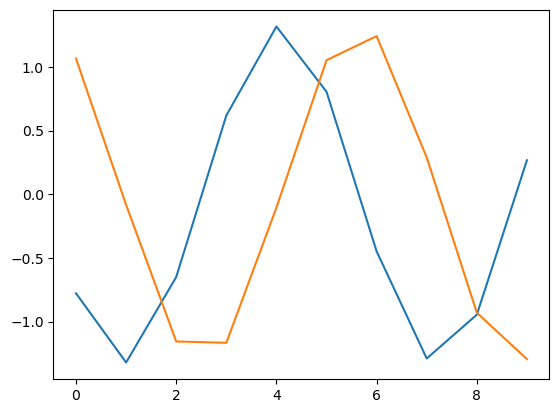

In [183]:
plt.plot(final_dataset[0, :, 0], label = "p")
plt.plot(final_dataset[0, :, 1], label = "q")
plt.show()

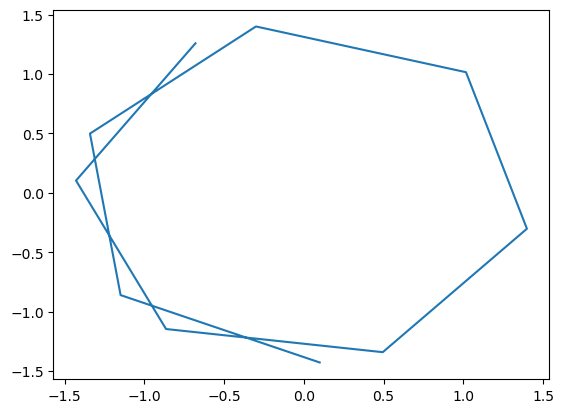

In [175]:
plt.plot(final_dataset[0, :, 0], final_dataset[0, :, 1])

In [185]:
np.save('harmonic_oscillator_dataset_1000.npy', dataset)
np.save('harmonic_oscillator_dataset_10.npy', dataset)

In [186]:
class HarmonicOscillatorDataset(Dataset):
    def __init__(self, file_path):
        # Load the dataset
        dataset = np.load(file_path)
        
        # Convert the dataset to PyTorch tensors
        self.p_values = torch.tensor(dataset[:, :, 0], dtype=torch.float32)
        self.q_values = torch.tensor(dataset[:, :, 1], dtype=torch.float32)
        self.h_values = torch.tensor(dataset[:, :, 2], dtype=torch.float32)
        
        # Ensure consistent length for all tensors
        assert len(self.p_values) == len(self.q_values) == len(self.h_values)
        self.length = len(self.p_values)
    
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        return self.p_values[idx], self.q_values[idx], self.h_values[idx]

In [187]:
class MLP1H_Separable_Hamilt(nn.Module):
    def __init__(self, n_hidden = 256, input_size = 1):
        super(MLP1H_Separable_Hamilt, self).__init__()
        self.linear_K1 = nn.Linear(input_size, n_hidden)
        self.linear_K2 = nn.Linear(n_hidden, 1)
        self.linear_P1 = nn.Linear(input_size, n_hidden)
        self.linear_P2 = nn.Linear(n_hidden, 1)

    def kinetic_energy(self, p):
        h_pre = self.linear_K1(p)
        h = h_pre.tanh_()
        return self.linear_K2(h)

    def potential_energy(self, q):
        h_pre = self.linear_P1(q)
        h = h_pre.tanh_()
        return self.linear_P2(h)

    def forward(self, p, q):
        return self.kinetic_energy(p) + self.potential_energy(q)

In [193]:
model = MLP1H_Separable_Hamilt(n_hidden = 256, input_size = 1)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create a DataLoader for the dataset
data_loader = DataLoader(harmonic_dataset, batch_size=32, shuffle=True)

t0 = 0
t1 = 10
dt = 0.1
num_steps = int((t1-t0)/dt)

num_epochs = 10
for epoch in tqdm(range(num_epochs)):
    total_loss = 0
    for batch in data_loader:
        # Unpack the batch
        p_batch, q_batch, _ = batch  # We don't need h_batch
        
        # Extract the initial coordinates (p0, q0) from the trajectory
        p0_batch = p_batch[:, 0]  # First time step
        q0_batch = q_batch[:, 0]  # First time step
        
        # Set requires_grad=True for input tensors
        p0_batch.requires_grad_(True)
        q0_batch.requires_grad_(True)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Initialize lists to store predicted trajectory
        predicted_p = [p0_batch]
        predicted_q = [q0_batch]
        
        # Euler integration to predict trajectory
        for _ in range(num_steps):
            # Forward pass to get dp/dt and dq/dt
            predicted_h = model(predicted_p[-1].unsqueeze(1), predicted_q[-1].unsqueeze(1))
            p_grad, = grad(predicted_h, predicted_p[-1], grad_outputs=torch.ones_like(predicted_h), create_graph=True)
            q_grad, = grad(predicted_h, predicted_q[-1], grad_outputs=torch.ones_like(predicted_h), create_graph=True)
            dpdt = -q_grad
            dqdt = p_grad
            
            # Euler integration to update p and q
            p_new = predicted_p[-1] + dpdt * dt
            q_new = predicted_q[-1] + dqdt * dt
            
            # Append predicted p and q to trajectory
            predicted_p.append(p_new)
            predicted_q.append(q_new)
        print("time steps")
        print(len(predicted_p))

        # Stack predicted p and q to form the predicted trajectory
        predicted_p_trajectory = torch.stack(predicted_p, dim=1)  # Shape: (batch_size, num_steps+1)
        predicted_q_trajectory = torch.stack(predicted_q, dim=1)  # Shape: (batch_size, num_steps+1)

        # Compute the loss (MSE between actual trajectory and predicted trajectory)
        loss = criterion(torch.cat([predicted_p_trajectory, predicted_q_trajectory], dim=2), torch.cat([p_batch, q_batch], dim=2))
        total_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    # Print average loss for this epoch
    print(f"Epoch {epoch+1}, Average Loss: {total_loss / len(data_loader)}")

100


  0%|                                                    | 0/10 [00:00<?, ?it/s]

time steps
101


IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)